In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as plts
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LogisticRegression
import scipy.optimize as optimize
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore") 

In [111]:
solar = pd.read_csv('SolarSurvey.csv')

### Data Cleaning

In [112]:
solar1 = solar.drop('Household_ID', axis =1)


In [113]:
solar1.isna().sum()

City                0
Latitude           70
House_Type        182
Roof_Type         339
Roof_Pitch         28
Roof_Azimuth       84
Floors            269
Financed            0
Year                0
Panel_Capacity      0
Shading            96
Generation          0
dtype: int64

In [114]:
solar1['Roof_Type'].unique()

array(['Steel', 'Tile', nan, 'Other', 'Colorbond'], dtype=object)

In [115]:
solar1['Latitude'].fillna(solar1['Latitude'].mean(), inplace=True)
solar1['House_Type'].fillna(solar1['House_Type'].mode()[0], inplace=True)
solar1['Roof_Type'].fillna(solar1['Roof_Type'].mode()[0], inplace=True)
solar1['Roof_Pitch'].fillna(solar1['Roof_Pitch'].median(), inplace=True)
solar1['Roof_Azimuth'].fillna(solar1['Roof_Azimuth'].median(), inplace=True)
solar1['Floors'].fillna('Other', inplace=True)
solar1 = solar1.dropna(subset=['Shading'])


In [116]:
solar1.isna().sum()

City              0
Latitude          0
House_Type        0
Roof_Type         0
Roof_Pitch        0
Roof_Azimuth      0
Floors            0
Financed          0
Year              0
Panel_Capacity    0
Shading           0
Generation        0
dtype: int64

### Preparation 

In [117]:
solar1 = solar1[solar1['Generation']>=0]


solar1['Roof_Type'] = solar1['Roof_Type'].replace('Colorbond', 'Other')

solar1['House_Type'] = solar1['House_Type'].replace('Weatherboard', 'Other')


solar1['newRoof_Azimuth'] = solar1['Roof_Azimuth']

for i in solar1.index:
    if solar1.loc[i,'Roof_Azimuth'] > 360 - solar1.loc[i,'Roof_Azimuth']:
        solar1.loc[i,'newRoof_Azimuth'] = 360 - solar1.loc[i,'Roof_Azimuth']

# solar1['Roof_Type'].unique()
solar1

,City,Latitude,House_Type,Roof_Type,Roof_Pitch,Roof_Azimuth,Floors,Financed,Year,Panel_Capacity,Shading,Generation,newRoof_Azimuth
0,Brisbane,-33.099042,Timber Frame,Steel,10.0,21.0,Double,No,2019,5040,None,10163.796,21.0
3,Brisbane,-27.042364,Timber Frame,Steel,35.0,247.0,Other,Yes,2012,5040,None,7747.349,113.0
4,Brisbane,-27.432734,Other,Steel,10.0,39.0,Double,Yes,2012,5880,None,10987.674,39.0
5,Brisbane,-27.677593,Timber Frame,Tile,12.5,158.0,Single,Yes,2020,7980,None,14452.109,158.0
6,Brisbane,-27.236922,Timber Frame,Tile,30.0,183.0,Other,No,2013,6300,Partial,6999.213,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Melbourne,-37.741982,Other,Tile,30.0,132.0,Single,Yes,2011,7560,Significant,4252.178,132.0
2996,Melbourne,-38.008012,Other,Tile,10.0,57.0,Double,Yes,2020,7140,Significant,5684.912,57.0
2997,Melbourne,-38.342210,Timber Frame,Tile,22.5,352.0,Single,Yes,2017,7140,None,12026.470,8.0
2998,Melbourne,-37.579522,Timber Frame,Tile,5.0,115.0,Single,No,2014,6300,None,8902.884,115.0


In [118]:
solar2 = solar1.copy()

solar2['Shading'] = solar2['Shading'].replace({'None': 1, 'Partial': 0.7, 'Significant': 0.5 })



solar2 = solar2.drop('Roof_Azimuth', axis=1)


solar2 = pd.get_dummies(solar2, drop_first=True)

solar2['Year_Cat'] = solar2['Year'].apply(lambda x: x - solar1['Year'].min() + 1)


solar2 = solar2.reset_index()
solar2 = solar2.drop('index', axis=1)
solar2


,Latitude,Roof_Pitch,Year,Panel_Capacity,Shading,Generation,newRoof_Azimuth,City_Melbourne,City_Sydney,House_Type_Other,House_Type_Timber Frame,Roof_Type_Steel,Roof_Type_Tile,Floors_Other,Floors_Single,Financed_Yes,Year_Cat
0,-33.099042,10.0,2019,5040,1.0,10163.796,21.0,0,0,0,1,1,0,0,0,0,19
1,-27.042364,35.0,2012,5040,1.0,7747.349,113.0,0,0,0,1,1,0,1,0,1,12
2,-27.432734,10.0,2012,5880,1.0,10987.674,39.0,0,0,1,0,1,0,0,0,1,12
3,-27.677593,12.5,2020,7980,1.0,14452.109,158.0,0,0,0,1,0,1,0,1,1,20
4,-27.236922,30.0,2013,6300,0.7,6999.213,177.0,0,0,0,1,0,1,1,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,-37.741982,30.0,2011,7560,0.5,4252.178,132.0,1,0,1,0,0,1,0,1,1,11
2886,-38.008012,10.0,2020,7140,0.5,5684.912,57.0,1,0,1,0,0,1,0,0,1,20
2887,-38.342210,22.5,2017,7140,1.0,12026.470,8.0,1,0,0,1,0,1,0,1,1,17
2888,-37.579522,5.0,2014,6300,1.0,8902.884,115.0,1,0,0,1,0,1,0,1,0,14


In [119]:
solar2['Shading_Panel_Capacity'] = solar2['Shading']*solar2['Panel_Capacity']
solar2['Latitude_Roof_Azimuth'] = solar2['Latitude']*solar2['newRoof_Azimuth']

solar2

,Latitude,Roof_Pitch,Year,Panel_Capacity,Shading,Generation,newRoof_Azimuth,City_Melbourne,City_Sydney,House_Type_Other,House_Type_Timber Frame,Roof_Type_Steel,Roof_Type_Tile,Floors_Other,Floors_Single,Financed_Yes,Year_Cat,Shading_Panel_Capacity,Latitude_Roof_Azimuth
0,-33.099042,10.0,2019,5040,1.0,10163.796,21.0,0,0,0,1,1,0,0,0,0,19,5040.0,-695.079878
1,-27.042364,35.0,2012,5040,1.0,7747.349,113.0,0,0,0,1,1,0,1,0,1,12,5040.0,-3055.787132
2,-27.432734,10.0,2012,5880,1.0,10987.674,39.0,0,0,1,0,1,0,0,0,1,12,5880.0,-1069.876626
3,-27.677593,12.5,2020,7980,1.0,14452.109,158.0,0,0,0,1,0,1,0,1,1,20,7980.0,-4373.059694
4,-27.236922,30.0,2013,6300,0.7,6999.213,177.0,0,0,0,1,0,1,1,0,0,13,4410.0,-4820.935194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,-37.741982,30.0,2011,7560,0.5,4252.178,132.0,1,0,1,0,0,1,0,1,1,11,3780.0,-4981.941624
2886,-38.008012,10.0,2020,7140,0.5,5684.912,57.0,1,0,1,0,0,1,0,0,1,20,3570.0,-2166.456684
2887,-38.342210,22.5,2017,7140,1.0,12026.470,8.0,1,0,0,1,0,1,0,1,1,17,7140.0,-306.737680
2888,-37.579522,5.0,2014,6300,1.0,8902.884,115.0,1,0,0,1,0,1,0,1,0,14,6300.0,-4321.645030


In [120]:
correlation = solar2.drop('Year', axis=1).corr()['Generation'].sort_values(ascending=False)
correlation = pd.DataFrame(correlation)
correlation = correlation.rename(columns={'Generation': 'Correlation Coefficient'})
correlation['Correlation Coefficient'] = correlation['Correlation Coefficient'].round(3)
correlation



,Correlation Coefficient
Generation,1.000
Shading_Panel_Capacity,0.784
Panel_Capacity,0.602
Shading,0.497
Latitude_Roof_Azimuth,0.464
Latitude,0.343
Year_Cat,0.157
Roof_Type_Steel,0.003
Financed_Yes,-0.003
Floors_Single,-0.004


### Train_Test_Vali

In [121]:
X = solar2.drop('Generation',axis=1)
y = solar2['Generation']

X_tv, X_test, y_tv, y_test = train_test_split(X,y,test_size=0.25, random_state =1)
X_train, X_vali, y_train, y_vali = train_test_split(X_tv, y_tv, test_size = 1/3,random_state=1)

# print(X.shape)
# print(y.shape)
# print(X_vali.shape)
# print(X_test.shape)
# print(X_test)

### Variables 

In [122]:
M1_variables = ['Shading_Panel_Capacity','Latitude_Roof_Azimuth']

M2_variables = ['Shading','Panel_Capacity','Latitude', 'newRoof_Azimuth']

M3_variables = ['Shading_Panel_Capacity','Latitude_Roof_Azimuth','Shading','Panel_Capacity','Latitude', 'newRoof_Azimuth']


### LinearRegression Model M1

In [123]:
M1_xtrain = X_train[M1_variables]
M1_ytrain = y_train


M1_xvali = X_vali[M1_variables]
M1_yvali = y_vali




M1 = LinearRegression().fit(M1_xtrain,M1_ytrain)


print('beta 0: {:.2f}'.format(M1.intercept_))
print('beta 1: {:.5f}'.format(M1.coef_[0]))
print('beta 2: {:.2f}'.format(M1.coef_[1]))


beta 0: 2648.00
beta 1: 1.47355
beta 2: 0.60


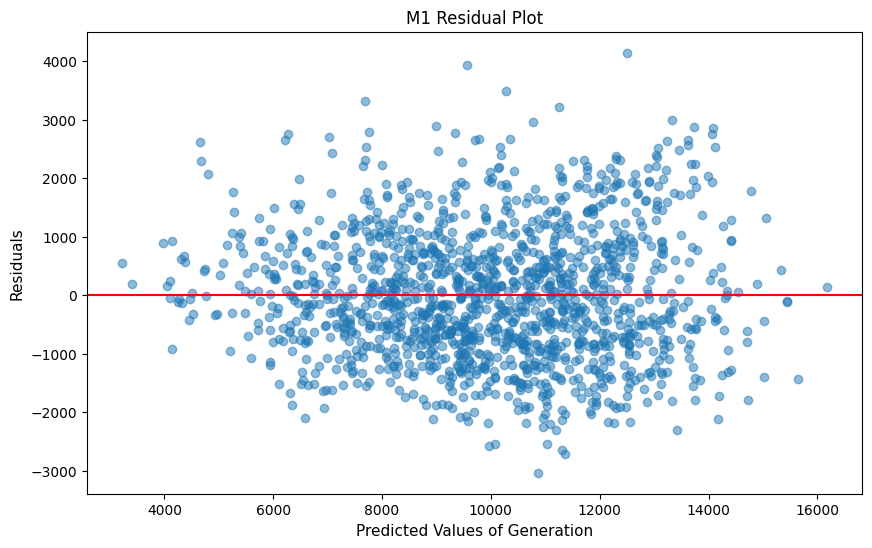

In [157]:
pred_M1 = M1.predict(M1_xtrain)
residuals = M1_ytrain - pred_M1

plt.figure(figsize = (10,6))
plt.scatter(pred_M1,residuals,alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values of Generation',fontsize = 11)
plt.ylabel('Residuals',fontsize = 11)
plt.title('M1 Residual Plot')
plt.show()


In [125]:
train_mse_M1 = mse(pred_M1, M1_ytrain)
print('MSE: {:.2f}'.format(train_mse_M1))

MSE: 1216500.76


In [126]:
# MSE using Validation Set 
vali_pred_M1 = M1.predict(M1_xvali)

vali_mse_M1 = mse(vali_pred_M1, M1_yvali,)
print('MSE: {:.2f}'.format(vali_mse_M1))

MSE: 1266196.67


### LinearRegression Model M2

In [127]:
M2_xtrain = X_train[M2_variables]
M2_ytrain = y_train


M2_xvali = X_vali[M2_variables]
M2_yvali = y_vali



M2 = LinearRegression().fit(M2_xtrain,M2_ytrain)


print('beta 0: {:.2f}'.format(M2.intercept_))
print('beta 1: {:.5f}'.format(M2.coef_[0]))
print('beta 2: {:.2f}'.format(M2.coef_[1]))
print('beta 3: {:.2f}'.format(M2.coef_[2]))
print('beta 4: {:.2f}'.format(M2.coef_[3]))

beta 0: 436.28
beta 1: 8425.46833
beta 2: 1.57
beta 3: 212.24
beta 4: -17.96


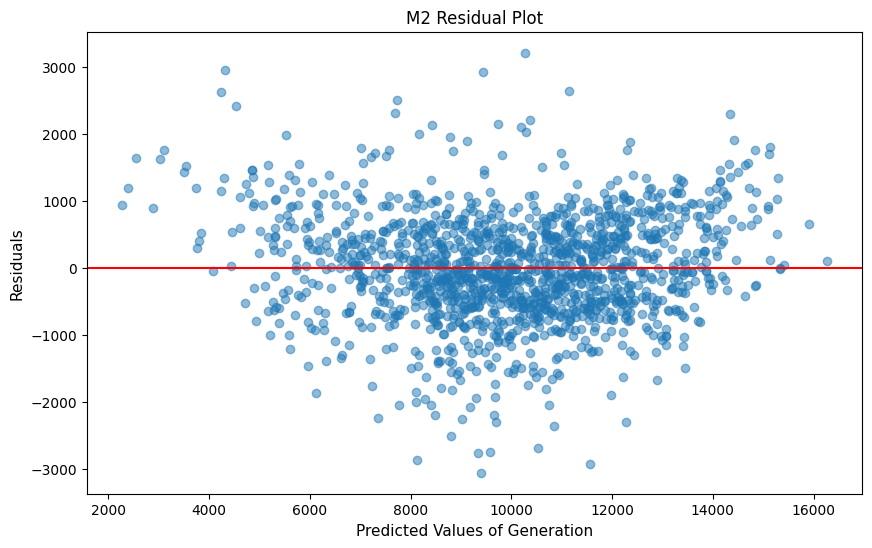

In [128]:
pred_M2 = M2.predict(M2_xtrain)
residuals = M2_ytrain - pred_M2

plt.figure(figsize = (10,6))
plt.scatter(pred_M2,residuals,alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values of Generation',fontsize = 11)
plt.ylabel('Residuals',fontsize = 11)
plt.title('M2 Residual Plot')
plt.show()

In [129]:
train_mse_M2 = mse(pred_M2, M2_ytrain)
print('MSE: {:.2f}'.format(train_mse_M2))

MSE: 635558.14


In [130]:
# MSE using Validation Set 
vali_pred_M2 = M2.predict(M2_xvali)

vali_mse_M2 = mse(vali_pred_M2, M2_yvali,)
print('MSE: {:.2f}'.format(vali_mse_M2))

MSE: 686909.86


### LinearRegression Model M3


In [131]:
M3_xtrain = X_train[M3_variables]
M3_ytrain = y_train


M3_xvali = X_vali[M3_variables]
M3_yvali = y_vali



M3 = LinearRegression().fit(M3_xtrain,M3_ytrain)


print('beta 0: {:.2f}'.format(M3.intercept_))
print('beta 1: {:.2f}'.format(M3.coef_[0]))
print('beta 2: {:.2f}'.format(M3.coef_[1]))
print('beta 3: {:.2f}'.format(M3.coef_[2]))
print('beta 4: {:.2f}'.format(M3.coef_[3]))
print('beta 5: {:.2f}'.format(M3.coef_[4]))
print('beta 6: {:.2f}'.format(M3.coef_[5]))

# M3_coef = M3.coef_
# for i in range(len(M3_coef)):
#     print(f'beta {i+1}: {M3_coef[i]:.2f}')
    

beta 0: 7596.87
beta 1: 1.21
beta 2: 0.05
beta 3: 667.14
beta 4: 0.44
beta 5: 209.97
beta 6: -16.27


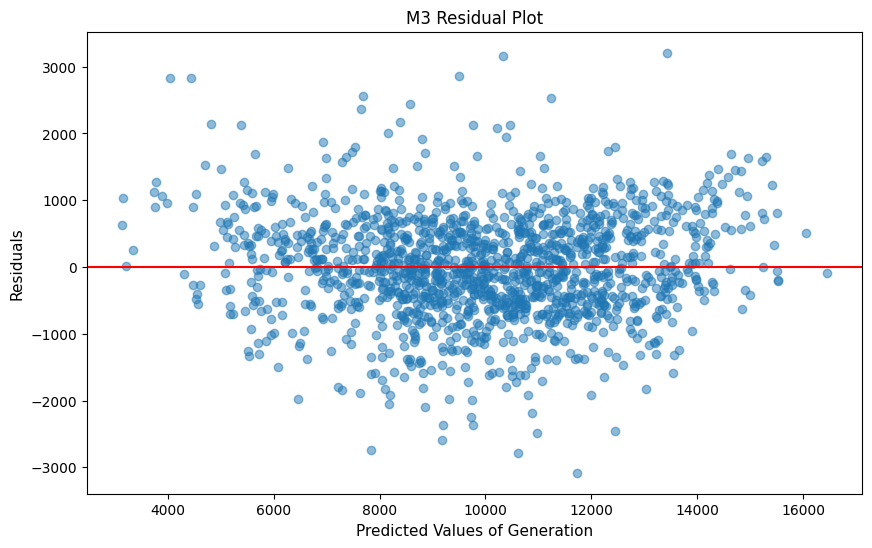

In [132]:
pred_M3 = M3.predict(M3_xtrain)
residuals = M3_ytrain - pred_M3

plt.figure(figsize = (10,6))
plt.scatter(pred_M3,residuals,alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values of Generation',fontsize = 11)
plt.ylabel('Residuals', fontsize = 11)
plt.title('M3 Residual Plot')
plt.show()

In [133]:
train_mse_M3 = mse(pred_M3, M3_ytrain)
print('MSE: {:.2f}'.format(train_mse_M3))

MSE: 607235.26


In [134]:

vali_pred_M3 = M3.predict(M3_xvali)

vali_mse_M3 = mse(vali_pred_M3, M3_yvali,)
print('MSE: {:.2f}'.format(vali_mse_M3))

MSE: 655426.64


### Bias-variance tradeoff

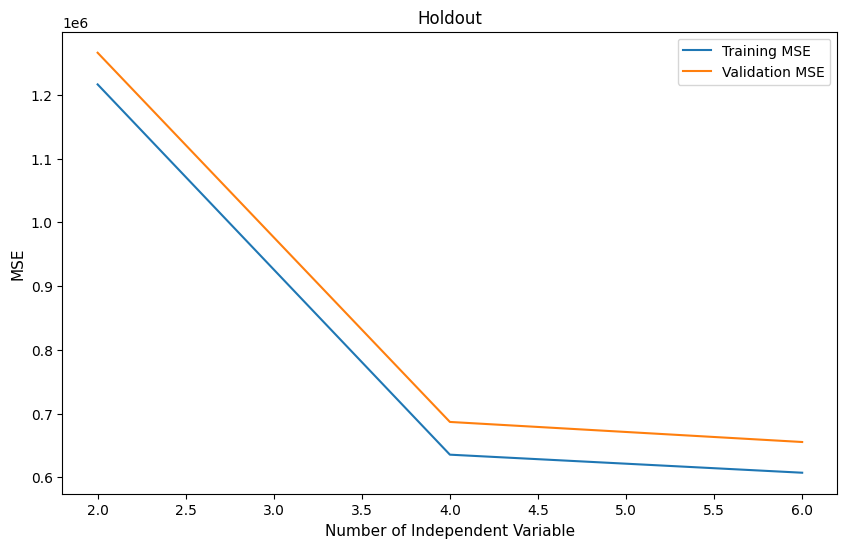

In [153]:
plt.figure(figsize = (10,6))
plt.plot([2,4,6],[train_mse_M1, train_mse_M2, train_mse_M3], alpha =1, label = 'Training MSE')
plt.plot([2,4,6],[vali_mse_M1, vali_mse_M2, vali_mse_M3], alpha =1, label = 'Validation MSE')
plt.xlabel('Number of Independent Variable', fontsize = 11)
plt.ylabel('MSE', fontsize = 11)
plt.title('Holdout', fontsize = 12)
plt.legend()
plt.show()





### Re-evaluation on test set 

In [136]:
M3_xtv = X_tv[M3_variables]
M3_ytv = y_tv

M3_xtest = X_test[M3_variables]
M3_ytest = y_test

M3_combine = LinearRegression().fit(M3_xtv,M3_ytv)


print('beta 0: {:.2f}'.format(M3_combine.intercept_))
M3_combine_coef = M3_combine.coef_
for i in range(len(M3_combine_coef)):
    print(f'beta {i+1}: {M3_combine_coef[i]:.2f}')

beta 0: 7483.84
beta 1: 1.20
beta 2: -0.04
beta 3: 841.13
beta 4: 0.46
beta 5: 214.14
beta 6: -19.34


In [137]:
M3_combine_tv_pred = M3_combine.predict(M3_xtv)
tv_mse_M3_combine = mse(M3_combine_tv_pred, M3_ytv)
print('MSE: {:.2f}'.format(tv_mse_M3_combine))

MSE: 621796.13


In [138]:
M3_combine_test_pred = M3_combine.predict(M3_xtest)

test_mse_M3_combine = mse(M3_combine_test_pred, M3_ytest,)
print('MSE: {:.2f}'.format(test_mse_M3_combine))

MSE: 564259.24


### Benchmark Model BM1

In [139]:
X_tv


,Latitude,Roof_Pitch,Year,Panel_Capacity,Shading,newRoof_Azimuth,City_Melbourne,City_Sydney,House_Type_Other,House_Type_Timber Frame,Roof_Type_Steel,Roof_Type_Tile,Floors_Other,Floors_Single,Financed_Yes,Year_Cat,Shading_Panel_Capacity,Latitude_Roof_Azimuth
2155,-38.140986,10.0,2019,6720,1.0,62.0,1,0,0,0,1,0,1,0,0,19,6720.0,-2364.741132
857,-27.714863,25.0,2015,7560,1.0,91.0,0,0,0,1,0,1,0,0,1,15,7560.0,-2522.052533
627,-27.299401,25.0,2019,5040,1.0,2.0,0,0,0,1,0,1,0,1,1,19,5040.0,-54.598802
2517,-37.961578,25.0,2015,5040,1.0,96.0,1,0,0,0,1,0,0,0,1,15,5040.0,-3644.311488
1986,-38.100782,25.0,2014,5040,1.0,6.0,1,0,0,1,0,1,0,1,1,14,5040.0,-228.604692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,-38.349556,5.0,2020,7980,1.0,33.0,1,0,0,1,1,0,1,0,0,20,7980.0,-1265.535348
905,-27.260303,35.0,2019,2940,1.0,165.0,0,0,0,0,0,1,1,0,0,19,2940.0,-4497.949995
1096,-33.898332,35.0,2018,6720,1.0,35.0,0,1,0,0,1,0,1,0,1,18,6720.0,-1186.441620
235,-27.458295,10.0,2021,7140,0.7,33.0,0,0,0,1,1,0,0,0,1,21,4998.0,-906.123735


In [140]:
solar1

,City,Latitude,House_Type,Roof_Type,Roof_Pitch,Roof_Azimuth,Floors,Financed,Year,Panel_Capacity,Shading,Generation,newRoof_Azimuth
0,Brisbane,-33.099042,Timber Frame,Steel,10.0,21.0,Double,No,2019,5040,None,10163.796,21.0
3,Brisbane,-27.042364,Timber Frame,Steel,35.0,247.0,Other,Yes,2012,5040,None,7747.349,113.0
4,Brisbane,-27.432734,Other,Steel,10.0,39.0,Double,Yes,2012,5880,None,10987.674,39.0
5,Brisbane,-27.677593,Timber Frame,Tile,12.5,158.0,Single,Yes,2020,7980,None,14452.109,158.0
6,Brisbane,-27.236922,Timber Frame,Tile,30.0,183.0,Other,No,2013,6300,Partial,6999.213,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Melbourne,-37.741982,Other,Tile,30.0,132.0,Single,Yes,2011,7560,Significant,4252.178,132.0
2996,Melbourne,-38.008012,Other,Tile,10.0,57.0,Double,Yes,2020,7140,Significant,5684.912,57.0
2997,Melbourne,-38.342210,Timber Frame,Tile,22.5,352.0,Single,Yes,2017,7140,None,12026.470,8.0
2998,Melbourne,-37.579522,Timber Frame,Tile,5.0,115.0,Single,No,2014,6300,None,8902.884,115.0


In [141]:
solar3 = solar1.copy()
solar3 = solar3.reset_index()
City_data = solar3.loc[X_tv.index]
City_data


,index,City,Latitude,House_Type,Roof_Type,Roof_Pitch,Roof_Azimuth,Floors,Financed,Year,Panel_Capacity,Shading,Generation,newRoof_Azimuth
2155,2239,Melbourne,-38.140986,Double Brick,Steel,10.0,62.0,Other,No,2019,6720,None,10486.850,62.0
857,887,Brisbane,-27.714863,Timber Frame,Tile,25.0,91.0,Double,Yes,2015,7560,None,13485.666,91.0
627,649,Brisbane,-27.299401,Timber Frame,Tile,25.0,2.0,Single,Yes,2019,5040,None,10693.000,2.0
2517,2612,Melbourne,-37.961578,Double Brick,Steel,25.0,96.0,Double,Yes,2015,5040,None,6950.111,96.0
1986,2064,Melbourne,-38.100782,Timber Frame,Tile,25.0,6.0,Single,Yes,2014,5040,None,8302.205,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2867,Melbourne,-38.349556,Timber Frame,Steel,5.0,327.0,Other,No,2020,7980,None,12580.163,33.0
905,940,Brisbane,-27.260303,Double Brick,Tile,35.0,165.0,Other,No,2019,2940,None,4204.653,165.0
1096,1139,Sydney,-33.898332,Double Brick,Steel,35.0,35.0,Other,Yes,2018,6720,None,12114.685,35.0
235,244,Brisbane,-27.458295,Timber Frame,Steel,10.0,33.0,Double,Yes,2021,7140,Partial,11744.958,33.0


In [142]:
Modern_system = City_data[(City_data['Year']>=2019)&(City_data['Year']<=2021)]

generation_city = Modern_system.groupby('City')['Generation'].mean()


solar4 = pd.merge(solar3,generation_city,on='City',how='left')
solar4.index = solar3.index
solar4

,index,City,Latitude,House_Type,Roof_Type,Roof_Pitch,Roof_Azimuth,Floors,Financed,Year,Panel_Capacity,Shading,Generation_x,newRoof_Azimuth,Generation_y
0,0,Brisbane,-33.099042,Timber Frame,Steel,10.0,21.0,Double,No,2019,5040,None,10163.796,21.0,11653.554517
1,3,Brisbane,-27.042364,Timber Frame,Steel,35.0,247.0,Other,Yes,2012,5040,None,7747.349,113.0,11653.554517
2,4,Brisbane,-27.432734,Other,Steel,10.0,39.0,Double,Yes,2012,5880,None,10987.674,39.0,11653.554517
3,5,Brisbane,-27.677593,Timber Frame,Tile,12.5,158.0,Single,Yes,2020,7980,None,14452.109,158.0,11653.554517
4,6,Brisbane,-27.236922,Timber Frame,Tile,30.0,183.0,Other,No,2013,6300,Partial,6999.213,177.0,11653.554517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,2995,Melbourne,-37.741982,Other,Tile,30.0,132.0,Single,Yes,2011,7560,Significant,4252.178,132.0,9168.702275
2886,2996,Melbourne,-38.008012,Other,Tile,10.0,57.0,Double,Yes,2020,7140,Significant,5684.912,57.0,9168.702275
2887,2997,Melbourne,-38.342210,Timber Frame,Tile,22.5,352.0,Single,Yes,2017,7140,None,12026.470,8.0,9168.702275
2888,2998,Melbourne,-37.579522,Timber Frame,Tile,5.0,115.0,Single,No,2014,6300,None,8902.884,115.0,9168.702275


In [143]:
BM1_pred = solar4.loc[X_test.index]['Generation_y']
BM1_pred

393     11653.554517
724     11653.554517
1539    10187.766128
563     11653.554517
2511     9168.702275
            ...     
1138    10187.766128
1964     9168.702275
2553     9168.702275
2185     9168.702275
2136     9168.702275
Name: Generation_y, Length: 723, dtype: float64

In [144]:
BM1_mse = mse(y_test, BM1_pred)
print('MSE: {:.2f}'.format(BM1_mse))

MSE: 5865573.16


### BM2

In [145]:
City_pcgen = Modern_system.groupby(['City','Panel_Capacity'])['Generation'].mean().reset_index()
City_pcgen

,City,Panel_Capacity,Generation
0,Brisbane,2940,4204.653000
1,Brisbane,3360,5587.609000
2,Brisbane,3780,6705.066000
3,Brisbane,4200,7475.049400
4,Brisbane,4620,8825.502600
5,Brisbane,5040,8501.882167
6,Brisbane,5460,9841.184160
7,Brisbane,5880,10365.589500
8,Brisbane,6300,10699.345600
9,Brisbane,6720,13098.606417


In [146]:
solar5 = pd.merge(solar3,City_pcgen,on=['City','Panel_Capacity'],how='left')
solar5.index = solar3.index
solar5

,index,City,Latitude,House_Type,Roof_Type,Roof_Pitch,Roof_Azimuth,Floors,Financed,Year,Panel_Capacity,Shading,Generation_x,newRoof_Azimuth,Generation_y
0,0,Brisbane,-33.099042,Timber Frame,Steel,10.0,21.0,Double,No,2019,5040,None,10163.796,21.0,8501.882167
1,3,Brisbane,-27.042364,Timber Frame,Steel,35.0,247.0,Other,Yes,2012,5040,None,7747.349,113.0,8501.882167
2,4,Brisbane,-27.432734,Other,Steel,10.0,39.0,Double,Yes,2012,5880,None,10987.674,39.0,10365.589500
3,5,Brisbane,-27.677593,Timber Frame,Tile,12.5,158.0,Single,Yes,2020,7980,None,14452.109,158.0,15246.882833
4,6,Brisbane,-27.236922,Timber Frame,Tile,30.0,183.0,Other,No,2013,6300,Partial,6999.213,177.0,10699.345600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,2995,Melbourne,-37.741982,Other,Tile,30.0,132.0,Single,Yes,2011,7560,Significant,4252.178,132.0,11684.554190
2886,2996,Melbourne,-38.008012,Other,Tile,10.0,57.0,Double,Yes,2020,7140,Significant,5684.912,57.0,9971.011000
2887,2997,Melbourne,-38.342210,Timber Frame,Tile,22.5,352.0,Single,Yes,2017,7140,None,12026.470,8.0,9971.011000
2888,2998,Melbourne,-37.579522,Timber Frame,Tile,5.0,115.0,Single,No,2014,6300,None,8902.884,115.0,8737.766907


In [147]:
BM2_pred = solar5.loc[X_test.index]['Generation_y']
BM2_pred

393     10365.589500
724      9841.184160
1539     9990.517852
563     10699.345600
2511     6622.091429
            ...     
1138     7992.280437
1964    11684.554190
2553     8737.766907
2185     9971.011000
2136    10101.826437
Name: Generation_y, Length: 723, dtype: float64

In [148]:
BM2_pred.isna()[BM2_pred.isna()==True]

2253    True
1894    True
899     True
1697    True
2015    True
Name: Generation_y, dtype: bool

In [149]:
BM2_pred = BM2_pred.drop([2253,1894,899,1697,2015])
y_test = y_test.drop([2253,1894,899,1697,2015])


In [150]:

BM2_mse = mse(y_test, BM2_pred)
print('MSE: {:.2f}'.format(BM2_mse))

MSE: 4110888.42
